In [96]:
import scipy.io
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

mat = scipy.io.loadmat("/disk/metabric/BRCA1View20000.mat")

In [97]:
gene_labels = [g[0] for g in mat['gene'][0]]
df = pd.DataFrame(mat['data'].transpose(), columns=gene_labels)
df.head()

,SCGB2A2,MUCL1,SCGB1D2,PIP,LOC648852,DNAJA2,TFF3,S100P,CPB1,CEACAM6,...,DLEU7,LOC641311,LOC645307,IL1RAP,LOC647149,LOC642453,LOC652100,LOC646050,LOC644912,LOC652294
0,6.365374,5.610561,5.134799,5.735802,5.855315,5.443985,8.005882,5.615179,6.682096,5.756946,...,5.441128,5.409726,5.420998,5.396492,5.358751,5.424770,5.411055,5.242460,5.197767,5.643537
1,14.330442,7.979139,10.244240,7.138279,9.890661,11.195867,13.511164,10.548596,5.491578,6.805606,...,5.392657,5.213895,5.167652,5.273045,5.287980,5.398061,5.226934,5.396744,5.352158,5.811813
2,14.388331,6.016715,12.164435,5.272691,6.468386,5.265518,13.386034,8.764722,7.331663,11.967719,...,5.328035,5.707537,5.327874,5.549589,5.333051,5.368544,5.296182,5.694022,5.459744,5.269015
3,13.111243,7.251862,8.389121,8.664654,10.378585,5.544646,11.159766,8.263224,5.497906,5.923506,...,5.410289,5.351022,5.009093,5.345468,5.176322,5.326991,5.480259,5.292691,5.242160,5.635111
4,12.243103,7.293489,10.919581,9.566137,8.503568,11.492583,11.531352,9.818938,9.443134,6.889670,...,5.402880,5.320883,5.487783,5.479967,5.332074,5.273141,5.282872,5.222482,5.186136,5.616094


Text(0.5, 1.0, 'Variance Drop Off after 0,1,2')

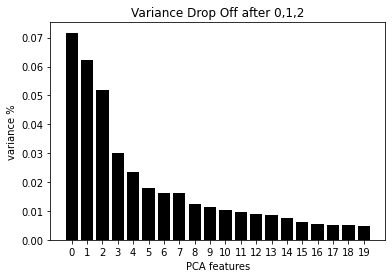

In [98]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)
# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
plt.title("Variance Drop Off after 0,1,2")

In [99]:
# PCA

Text(0, 0.5, 'PCA 2')

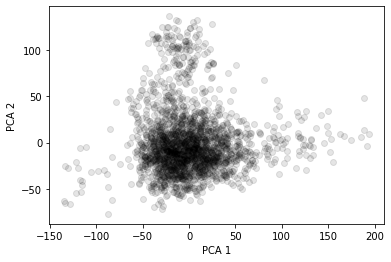

In [100]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

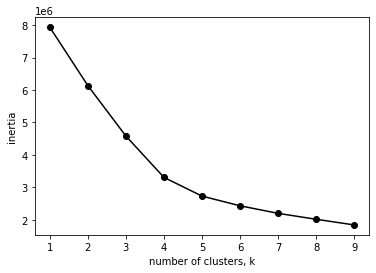

In [101]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [102]:
model = KMeans(n_clusters=4)
    
# Fit model to samples
model.fit(PCA_components.iloc[:,:3])

KMeans(n_clusters=4)

In [103]:
df['kmean-label'] = model.labels_

In [104]:
df['target'] = mat['targets']
df['Subtype'] = df.target.map({1:'Basal',2:'HER2+',3:'LumA',4:'LumB',5:'Normal Like',6:'Normal'})

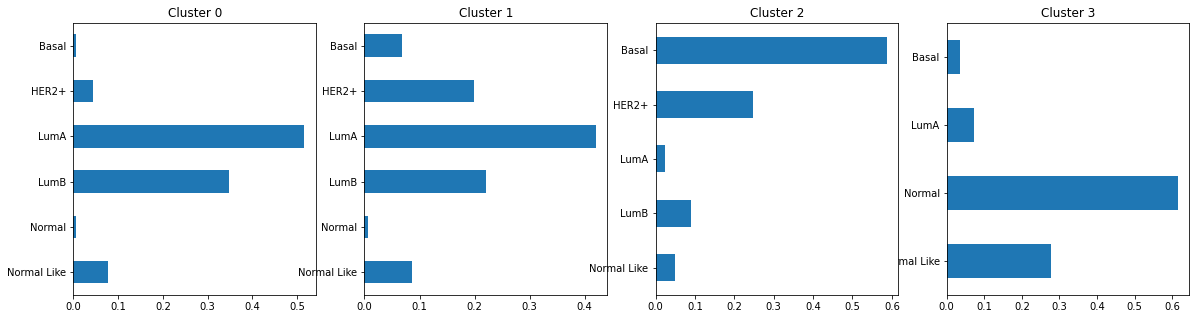

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure(figsize=(20,5)) 

# Target Label in each Cluster
for i in df['kmean-label'].unique():
    plt.subplot(1,4,i+1)
    vs = (df[df['kmean-label'] == i]['Subtype'].value_counts(normalize=True))
    vs.sort_index(ascending=False).plot(kind = 'barh')
    plt.title(f"Cluster {i}")

In [190]:
import random

test_size = 200
val_size = 30
train_size = 1903

sets = []

for cluster in df['kmean-label'].unique():
    curr = pd.DataFrame(index=range(2133),columns=["train", "test", "val"])
    for i in range(25):
        random.seed(i)
        shifted_set = df[df['kmean-label'] == cluster].index.values
        
        test_list = shifted_set[random.sample(range(0, len(shifted_set)), 200)]
        
        shifted_set = np.array(list(set(shifted_set) - set(test_list)))
        
        val_list = shifted_set[random.sample(range(0, len(shifted_set)), 30)]
        
        #remnants = list(set(shifted_set) - set(test_list) - set(val_list))
        
        train_list = list(set(range(0,2133)) - set(test_list) - set(val_list))
        
        #print(len(train_list), len(val_list), len(test_list))

        for r in range(2133):
            curr.at[r, 'val'] = [True if r in val_list else False][0]
            curr.at[r, 'test'] = [True if r in test_list else False][0]
            curr.at[r, 'train'] = [True if r in train_list else False][0]
        sets.append(curr)